In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

In [ ]:
pd.read_csv()

# Load data

In [2]:
# load reanalysis data
ds = xr.load_dataset("data/Tokyo1.nc")

# load station data
df_st = pd.read_csv("data/RJAA - 1990-2019.txt")

# Peek at data

In [3]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 1, time: 43824)
Coordinates:
  * longitude  (longitude) float32 139.52
  * latitude   (latitude) float32 35.7 35.6
  * time       (time) datetime64[ns] 1990-01-01 ... 1994-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 267.4438 ... 267.51898
    t2m        (time, latitude, longitude) float32 274.84668 ... 273.94727
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-03 18:13:00 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
df_st

,station,valid,tmpc,dwpc,relh,alti,mslp
0,RJAA,1990-01-01 00:00,4.00,-4.00,55.95,29.96,M
1,RJAA,1990-01-01 01:00,6.00,-6.00,41.84,29.95,M
2,RJAA,1990-01-01 01:22,4.00,-4.00,55.95,29.96,M
3,RJAA,1990-01-01 01:30,6.00,-6.00,41.84,29.95,M
4,RJAA,1990-01-01 02:00,6.00,-6.00,41.84,29.93,M
...,...,...,...,...,...,...,...
518028,RJAA,2019-12-30 21:47,6.00,5.00,93.30,29.83,M
518029,RJAA,2019-12-30 22:00,6.00,5.00,93.30,29.83,M
518030,RJAA,2019-12-30 22:30,6.00,6.00,100.00,29.80,M
518031,RJAA,2019-12-30 23:00,7.00,6.00,93.35,29.80,M


In [5]:
df_st.describe()

,station,valid,tmpc,dwpc,relh,alti,mslp
count,518033,518033,518033,518033,518033,518033,518033
unique,1,507774,50,52,935,185,1
top,RJAA,2011-11-20 07:00,19.00,23.00,100.00,29.91,M
freq,518033,15,22470,22409,40829,26540,518033


# Process data

In [6]:
# convert temperatures to celsius, add as a new variables in ds
ds["d2m_C"] = ds["d2m"] - 273.15
ds["t2m_C"] = ds["t2m"] - 273.15

In [7]:
# define a function for calculating RH
RH = lambda TD, T: 100 * np.exp((17.625*TD)/(243.04+TD)) / np.exp((17.625*T)/(243.04+T))

# calculate RH for every data point in ds, add as a new variables in ds
ds["relh"] = RH(ds["d2m_C"], ds["t2m_C"])

# convert rh data to pandas dataframe
rh_data = ds["relh"].to_dataframe()

In [8]:
# peek at data
rh_data

relh
time                latitude  longitude            
1990-01-01 00:00:00 35.700001 139.520004  57.929352
                    35.599998 139.520004  57.117096
1990-01-01 01:00:00 35.700001 139.520004  45.704300
                    35.599998 139.520004  44.540039
1990-01-01 02:00:00 35.700001 139.520004  42.695911
...                                             ...
1994-12-31 21:00:00 35.599998 139.520004  59.194332
1994-12-31 22:00:00 35.700001 139.520004  62.929878
                    35.599998 139.520004  61.156345
1994-12-31 23:00:00 35.700001 139.520004  62.598545
                    35.599998 139.520004  62.146923

[87648 rows x 1 columns]

In [9]:
# reshape dataframe so columns are lat and long, index (rows) is time
rh_data = rh_data.unstack(level=[-1,-2]).droplevel(0, axis=1)
rh_data

longitude           139.520004           
latitude             35.700001  35.599998
time                                     
1990-01-01 00:00:00  57.929352  57.117096
1990-01-01 01:00:00  45.704300  44.540039
1990-01-01 02:00:00  42.695911  41.284557
1990-01-01 03:00:00  41.364182  39.878468
1990-01-01 04:00:00  38.810238  38.511993
...                        ...        ...
1994-12-31 19:00:00  60.039562  57.916557
1994-12-31 20:00:00  60.528069  58.704441
1994-12-31 21:00:00  61.132744  59.194332
1994-12-31 22:00:00  62.929878  61.156345
1994-12-31 23:00:00  62.598545  62.146923

[43824 rows x 2 columns]

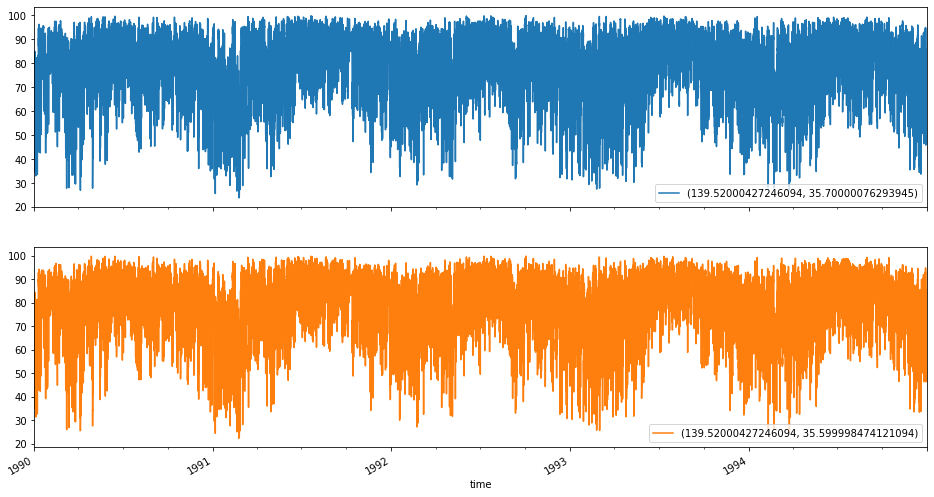

In [10]:
# plot rh data
rh_data.plot(subplots=True, figsize=(16,9))
plt.show()

## Advanced processing

In [11]:
# grouby daily
grpby = rh_data.groupby(pd.Grouper(freq="D"))

# custom aggregation - count how many records above 60
above_60 = lambda s: (s > 60).sum()

# calculate aggregations for daily data
rh_data_D = grpby.agg(["min", "mean", "max", ("above_60", above_60)])

# name levels in columns
rh_data_D.columns.names = ["lon", "lat", "agg"]

In [12]:
rh_data_D

lon        139.520004                                                       \
lat         35.700001                                 35.599998              
agg               min       mean        max above_60        min       mean   
time                                                                         
1990-01-01  34.791996  64.927673  81.469475     16.0  35.026657  63.951096   
1990-01-02  46.889584  69.406578  84.815903     17.0  46.999115  67.621201   
1990-01-03  43.504536  60.968670  77.858948     11.0  43.615299  59.685642   
1990-01-04  33.022404  55.994148  70.146751     14.0  31.317862  53.542171   
1990-01-05  38.017418  66.868652  82.234818     16.0  38.326344  65.308418   
...               ...        ...        ...      ...        ...        ...   
1994-12-27  66.039009  85.133408  93.340897     24.0  66.267052  82.661476   
1994-12-28  69.153610  84.856850  94.878410     24.0  67.818092  83.638962   
1994-12-29  45.838902  64.930603  81.539520     16.0  46.272739  62.181366   
1994-12-30  47.109001  68.465408  85.734016     17.0  46.710304  67.384491   
1994-12-31  53.398300  63.010757  76.992004     17.0  51.285652  61.945038   

lon                             
lat                             
agg               max above_60  
time                            
1990-01-01  80.564148     14.0  
1990-01-02  84.369530     17.0  
1990-01-03  78.500641     10.0  
1990-01-04  73.853859     13.0  
1990-01-05  81.230171     15.0  
...               ...      ...  
1994-12-27  89.705315     24.0  
1994-12-28  94.807579     24.0  
1994-12-29  81.662048     15.0  
1994-12-30  85.547089     14.0  
1994-12-31  76.021332     14.0  

[1826 rows x 8 columns]

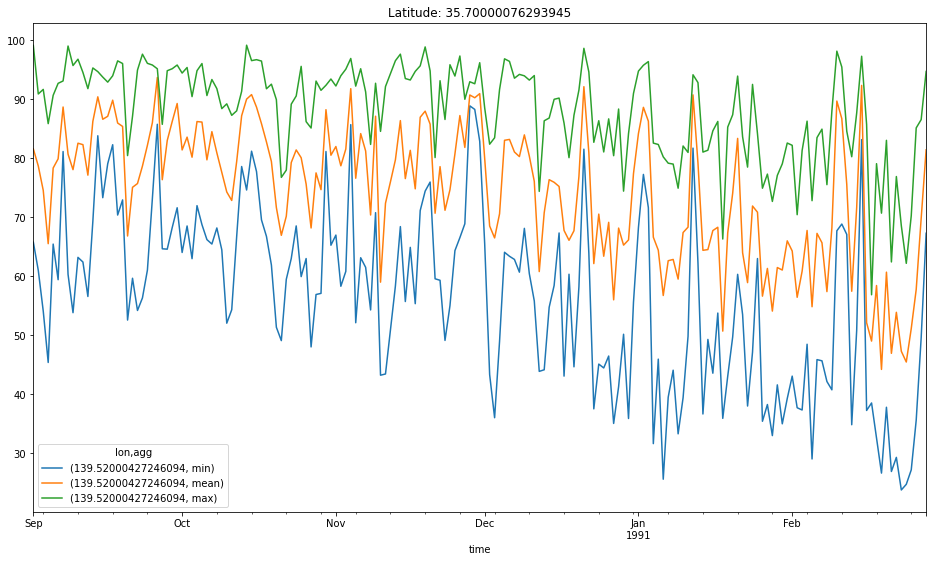

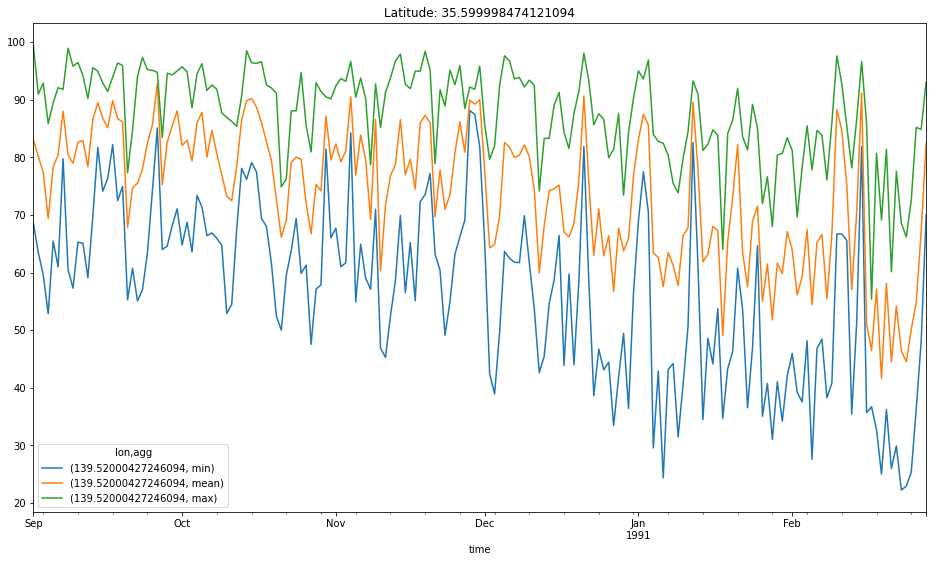

In [13]:
# iterate over lat
for l in rh_data_D.columns.unique(level=1):
    
    # select data for one location
    df1 = rh_data_D.xs(l, level=1, axis=1)
    
    # plot min, mean, max
    df1.loc["1990-09":"1991-02", (slice(None), ["min", "mean", "max"])].plot(figsize=(16,9), 
                                                                             title=f"Latitude: {l}")

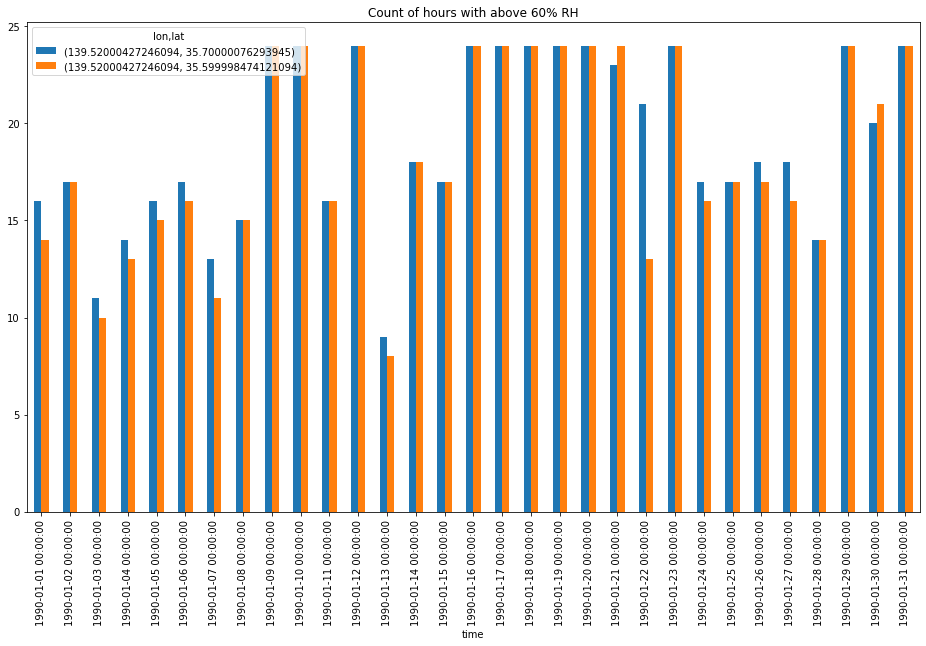

In [14]:
rh_data_D["1990-01"].xs("above_60", level=-1, axis=1).plot(kind="bar", figsize=(16,9), 
                                                           title="Count of hours with above 60% RH")
plt.show()